In [1]:
import treecorr

from random import *
import math
import numpy as np
import astropy.table
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_specgals

In [2]:
from astroML.datasets import fetch_sdss_specgals

# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7
# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]
# RA/DEC cuts
RAmin, RAmax = 140, 220 
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax] 
data = data[data['ra'] > RAmin] 
data = data[data['dec'] < DECmax] 
data = data[data['dec'] > DECmin]
ur = data['modelMag_u'] - data['modelMag_r'] 
flag_red = (ur > 2.22)
flag_blue = ~flag_red
data_red = data[flag_red] 
data_blue = data[flag_blue]
print("data size:")
print(" red gals: ", len(data_red)) 
print(" blue gals:", len(data_blue))

data size:
 red gals:  38017
 blue gals: 16883


In [3]:
nn_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='jackknife')

cat_red = treecorr.Catalog(ra = data_red['ra'], dec = data_red['dec'],
                             ra_units='deg', dec_units='deg', npatch = 100)

nn_red.process(cat_red)

ra_range_red = max(cat_red.ra) - min(cat_red.ra)
dec_range_red = max(cat_red.dec) - min(cat_red.dec)
ra_min_red = min(cat_red.ra)
dec_min_red = min(cat_red.dec)

rand_ra_red = []
rand_dec_red = []

min_cth = np.min(np.sin(cat_red.dec))
max_cth = np.max(np.sin(cat_red.dec))
rand_dec_red = np.arcsin(min_cth+(max_cth-min_cth)*np.random.random(size=len(data_red))) 

for i in range(len(data_red)):
    u = random()
    rand_ra_red.append((2*math.pi*u)*(ra_range_red/(2*math.pi)) + ra_min_red)
    
rr_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='jackknife')
catrand_red = treecorr.Catalog(ra = rand_ra_red, dec = rand_dec_red, ra_units='rad', dec_units='rad')
rr_red.process(catrand_red)

dr_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6,sep_units = 'deg', var_method='jackknife')
dr_red.process(cat_red, catrand_red)

bin_centers_red = nn_red.meanlogr

corr_red = nn_red.calculateXi(rr_red, dr_red)

In [4]:
nn_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='jackknife')

cat_blue = treecorr.Catalog(ra = data_blue['ra'], dec = data_blue['dec'], 
                            ra_units='deg', dec_units='deg', npatch = 100)

nn_blue.process(cat_blue)

ra_range_blue = max(cat_blue.ra) - min(cat_blue.ra)
dec_range_blue = max(cat_blue.dec) - min(cat_blue.dec)
ra_min_blue = min(cat_blue.ra)
dec_min_blue = min(cat_blue.dec)

rand_ra_blue = []
rand_dec_blue = []

min_cth = np.min(np.sin(cat_blue.dec))
max_cth = np.max(np.sin(cat_blue.dec))
rand_dec_blue = np.arcsin(min_cth+(max_cth-min_cth)*np.random.random(size=len(data_blue))) 

for i in range(len(data_blue)):
    u = random()
    rand_ra_blue.append((2*math.pi*u)*(ra_range_blue/(2*math.pi)) + ra_min_blue)
    
rr_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='jackknife')
catrand_blue = treecorr.Catalog(ra = rand_ra_blue, dec = rand_dec_blue, ra_units='rad', dec_units='rad')
rr_blue.process(catrand_blue)

dr_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6,sep_units = 'deg', var_method='jackknife')
dr_blue.process(cat_blue, catrand_blue)

bin_centers_blue = nn_blue.meanlogr

corr_blue = nn_blue.calculateXi(rr_blue, dr_blue)

In [5]:
corr = [corr_red, corr_blue]
bin_centers = [bin_centers_red, bin_centers_blue]

corr_stdev_red = [math.sqrt(k) for k in corr[0][1]]
corr_stdev_blue = [math.sqrt(k) for k in corr[1][1]]

corr_stdev = [corr_stdev_red, corr_stdev_blue]

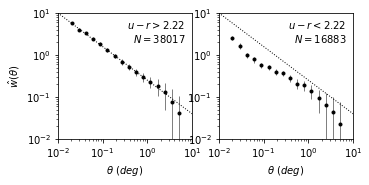

In [6]:
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5.0, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
for i in range(2):
    ax = fig.add_subplot(121 + i)
    
    ax.set_ylim([10**(-2),10])
    ax.set_yscale('log')
    
    ax.set_xlim([10**(-2),10])
    ax.set_xscale('log')
    
    ax.errorbar(math.e**bin_centers[i], corr[i][0], corr_stdev[i], fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    #plt.scatter(math.e**(bin_centers[i]),corr[i][0])
    
    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')

In [10]:
"""

The Bootstrap method, for comparison

"""

nn_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='bootstrap')

cat_red = treecorr.Catalog(ra = data_red['ra'], dec = data_red['dec'],
                             ra_units='deg', dec_units='deg', npatch = 100)

nn_red.process(cat_red)

ra_range_red = max(cat_red.ra) - min(cat_red.ra)
dec_range_red = max(cat_red.dec) - min(cat_red.dec)
ra_min_red = min(cat_red.ra)
dec_min_red = min(cat_red.dec)

rand_ra_red = []
rand_dec_red = []

min_cth = np.min(np.sin(cat_red.dec))
max_cth = np.max(np.sin(cat_red.dec))
rand_dec_red = np.arcsin(min_cth+(max_cth-min_cth)*np.random.random(size=len(data_red))) 

for i in range(len(data_red)):
    u = random()
    rand_ra_red.append((2*math.pi*u)*(ra_range_red/(2*math.pi)) + ra_min_red)
    
rr_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='bootstrap')
catrand_red = treecorr.Catalog(ra = rand_ra_red, dec = rand_dec_red, ra_units='rad', dec_units='rad')
rr_red.process(catrand_red)

dr_red = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6,sep_units = 'deg', var_method='bootstrap')
dr_red.process(cat_red, catrand_red)

bin_centers_red = nn_red.meanlogr

corr_red = nn_red.calculateXi(rr_red, dr_red)

In [11]:
nn_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='bootstrap')

cat_blue = treecorr.Catalog(ra = data_blue['ra'], dec = data_blue['dec'], 
                            ra_units='deg', dec_units='deg', npatch = 100)

nn_blue.process(cat_blue)

ra_range_blue = max(cat_blue.ra) - min(cat_blue.ra)
dec_range_blue = max(cat_blue.dec) - min(cat_blue.dec)
ra_min_blue = min(cat_blue.ra)
dec_min_blue = min(cat_blue.dec)

rand_ra_blue = []
rand_dec_blue = []

min_cth = np.min(np.sin(cat_blue.dec))
max_cth = np.max(np.sin(cat_blue.dec))
rand_dec_blue = np.arcsin(min_cth+(max_cth-min_cth)*np.random.random(size=len(data_blue))) 

for i in range(len(data_blue)):
    u = random()
    rand_ra_blue.append((2*math.pi*u)*(ra_range_blue/(2*math.pi)) + ra_min_blue)
    
rr_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg', var_method='bootstrap')
catrand_blue = treecorr.Catalog(ra = rand_ra_blue, dec = rand_dec_blue, ra_units='rad', dec_units='rad')
rr_blue.process(catrand_blue)

dr_blue = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6,sep_units = 'deg', var_method='bootstrap')
dr_blue.process(cat_blue, catrand_blue)

bin_centers_blue = nn_blue.meanlogr

corr_blue = nn_blue.calculateXi(rr_blue, dr_blue)

In [12]:
corr = [corr_red, corr_blue]
bin_centers = [bin_centers_red, bin_centers_blue]

corr_stdev_red = [math.sqrt(k) for k in corr[0][1]]
corr_stdev_blue = [math.sqrt(k) for k in corr[1][1]]

corr_stdev = [corr_stdev_red, corr_stdev_blue]

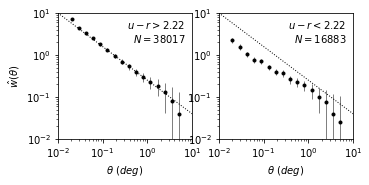

In [13]:
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5.0, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
for i in range(2):
    ax = fig.add_subplot(121 + i)
    
    ax.set_ylim([10**(-2),10])
    ax.set_yscale('log')
    
    ax.set_xlim([10**(-2),10])
    ax.set_xscale('log')
    
    ax.errorbar(math.e**bin_centers[i], corr[i][0], corr_stdev[i], fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    #plt.scatter(math.e**(bin_centers[i]),corr[i][0])
    
    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')